In [22]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

import matplotlib.style as style
%matplotlib inline

import warnings
warnings.simplefilter("ignore")
    
# read dataset
df = pd.read_csv('data_credit_card_customer_seg.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Data cleaning

In [4]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [5]:
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(), inplace=True)
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean(), inplace=True)

In [6]:
df.isnull().sum().sum()

0

In [7]:
# drop unnecessary columns
df = df.drop(columns=['CUST_ID'],axis=1)

## Feature engineering

### 1. Types of Purchases (one-off, installments)
what type of purchases customers are making on credit card

In [8]:
df.loc[:,['ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES']].head()

,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES
0,0.00,95.4
1,0.00,0.0
2,773.17,0.0
3,1499.00,0.0
4,16.00,0.0


In [9]:
def purchase(df):
    if (df['ONEOFF_PURCHASES'] == 0) & (df['INSTALLMENTS_PURCHASES'] == 0):
        return 'none'

    if (df['ONEOFF_PURCHASES'] > 0) & (df['INSTALLMENTS_PURCHASES'] > 0):
        return 'both'

    if (df['ONEOFF_PURCHASES'] > 0) & (df['INSTALLMENTS_PURCHASES'] == 0):
        return 'one_off'

    if (df['ONEOFF_PURCHASES'] == 0) & (df['INSTALLMENTS_PURCHASES'] > 0):
        return 'installment'


df['purchase_type'] = df.apply(purchase, axis=1)

df['purchase_type'].value_counts()

both           2774
installment    2260
none           2042
one_off        1874
Name: purchase_type, dtype: int64

### 2. Credit score
Lower value implies cutomers are maintaing thier balance properly. And it means good credit score

In [11]:
df['credit_score']=df.apply(lambda x: x['BALANCE']/x['CREDIT_LIMIT'], axis=1)
df['credit_score'].head()

0    0.040901
1    0.457495
2    0.332687
3    0.222223
4    0.681429
Name: credit_score, dtype: float64

### 3. Monthly average purchase

In [12]:
df['Monthly_avg_purch']=df['PURCHASES']/df['TENURE']

In [13]:
df.loc[:,['PURCHASES','TENURE','Monthly_avg_purch']].head()

,PURCHASES,TENURE,Monthly_avg_purch
0,95.40,12,7.950000
1,0.00,12,0.000000
2,773.17,12,64.430833
3,1499.00,12,124.916667
4,16.00,12,1.333333


### 4. Monthly cash advance amount

In [14]:
df['Monthly_cash_advance']=df['CASH_ADVANCE']/df['TENURE']
df['Monthly_cash_advance'].head()

0      0.000000
1    536.912124
2      0.000000
3     17.149001
4      0.000000
Name: Monthly_cash_advance, dtype: float64

### 5. Ratio payments to minimum payments

In [15]:
df['payment_minimum_pay']=df.apply(lambda x:x['PAYMENTS']/x['MINIMUM_PAYMENTS'],axis=1)
df['payment_minimum_pay']

0       1.446508
1       3.826241
2       0.991682
3       0.000000
4       2.771075
          ...   
8945    6.660231
8946    0.319208
8947    0.986076
8948    0.942505
8949    0.715439
Name: payment_minimum_pay, Length: 8950, dtype: float64

### 6. Total purchase amount

In [16]:
df['TOTAL_PURCH_AMT'] = pd.DataFrame(data=df,columns=['PURCHASES','CASH_ADVANCE']).sum(axis=1)
df['TOTAL_PURCH_AMT'].head()

0      95.400000
1    6442.945483
2     773.170000
3    1704.788017
4      16.000000
Name: TOTAL_PURCH_AMT, dtype: float64

### 7. Total transaction

In [17]:
df['TOTAL_TRX'] = pd.DataFrame(data=df,columns=['PURCHASES_TRX','CASH_ADVANCE_TRX']).sum(axis=1)
df['TOTAL_TRX'].head()

0     2
1     4
2    12
3     2
4     1
Name: TOTAL_TRX, dtype: int64

In [18]:
df=pd.concat([df,pd.get_dummies(df['purchase_type'])],axis=1)

In [19]:
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,credit_score,Monthly_avg_purch,Monthly_cash_advance,payment_minimum_pay,TOTAL_PURCH_AMT,TOTAL_TRX,both,installment,none,one_off
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,0.040901,7.950000,0.000000,1.446508,95.400000,2,0,1,0,0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,...,0.457495,0.000000,536.912124,3.826241,6442.945483,4,0,0,1,0
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.332687,64.430833,0.000000,0.991682,773.170000,12,0,0,0,1
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,0.222223,124.916667,17.149001,0.000000,1704.788017,2,0,0,0,1
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,0.681429,1.333333,0.000000,2.771075,16.000000,1,0,0,0,1


In [20]:
df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE', 'purchase_type', 'credit_score', 'Monthly_avg_purch',
       'Monthly_cash_advance', 'payment_minimum_pay', 'TOTAL_PURCH_AMT',
       'TOTAL_TRX', 'both', 'installment', 'none', 'one_off'],
      dtype='object')

In [26]:
df = df.drop(columns=['purchase_type'],axis=1)

## Data Normalization

In [31]:
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(df) 

# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 

## Dimension Reduction using PCA

In [32]:
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
X_principal.head(2)

,P1,P2
0,-0.160058,-0.764859
1,-0.579651,0.426714


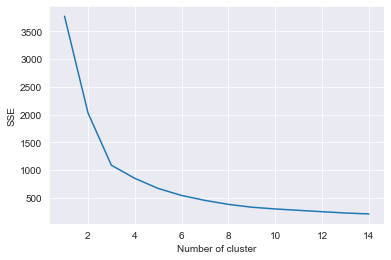

In [35]:
sns.set_style('darkgrid')
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_principal)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

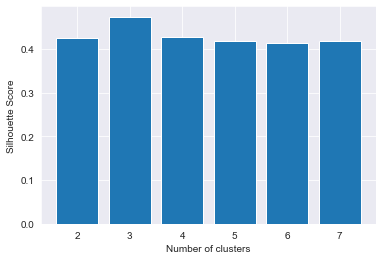

In [36]:
silhouette_scores = []

for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(X_principal, KMeans(n_clusters = n_cluster).fit_predict(X_principal))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6, 7] 

plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

Highest silhouette score is k = 3.

# Kmeans

In [37]:
kmean= KMeans(3)
kmean.fit(scaled_df)
labels=kmean.labels_

In [39]:
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,Monthly_avg_purch,Monthly_cash_advance,payment_minimum_pay,TOTAL_PURCH_AMT,TOTAL_TRX,both,installment,none,one_off,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,7.950000,0.000000,1.446508,95.400000,2,0,1,0,0,1
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,...,0.000000,536.912124,3.826241,6442.945483,4,0,0,1,0,2
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,64.430833,0.000000,0.991682,773.170000,12,0,0,0,1,1
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,124.916667,17.149001,0.000000,1704.788017,2,0,0,0,1,1
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,1.333333,0.000000,2.771075,16.000000,1,0,0,0,1,1


In [40]:
clusters['cluster'].value_counts()

1    5280
2    2866
0     804
Name: cluster, dtype: int64

In [41]:
clusters.groupby('cluster').mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,credit_score,Monthly_avg_purch,Monthly_cash_advance,payment_minimum_pay,TOTAL_PURCH_AMT,TOTAL_TRX,both,installment,none,one_off
cluster,,,,,,,,,,,,,,,,,,,,,
0,3140.512091,0.985607,5435.644067,3508.551281,1927.839055,1212.048986,0.949875,0.684675,0.792965,0.119616,...,0.380048,458.431098,105.049355,11.647044,6647.693053,73.569652,0.925373,0.024876,0.000000,0.049751
1,772.982419,0.844697,790.868797,409.591456,381.653280,174.604138,0.631271,0.208737,0.470101,0.039456,...,0.279296,68.792452,15.626237,9.285767,965.472936,13.915530,0.346023,0.398864,0.001894,0.253220
2,2580.506216,0.906890,150.955401,111.233897,39.756978,2395.149764,0.101823,0.055613,0.049560,0.315785,...,0.593254,13.770080,219.604586,7.843757,2546.105165,9.806699,0.070830,0.046755,0.709002,0.173412


In [ ]:
Balance              : high
Balance Frequency    : high (updated frequently)
Purchase             : medium
Purchase Frequency   : high
Cash Advance         : medium
Total purchase       : high
both                 : high
installment          : low
one_off              : very low
none                 : -
credit score         : medium

In [ ]:
Balance              : high
Balance Frequency    : high (updated frequently)
Purchase             : low
Purchase Frequency   : medium
Cash Advance         : low
Total purchase       : low
both                 : medium
installment          : medium
one_off              : medium
none                 : low
credit score         : low

In [ ]:
Balance              : high
Balance Frequency    : high (updated frequently)
Purchase             : low  
Purchase Frequency   : low
Cash Advance         : high
Total purchase       : medium
both                 : very low
installment          : low
one_off              : low
none                 : high
credit score         : high

## Visualization

In [42]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_df)
principalDf = pd.DataFrame(data = principalComponents, columns=['principal component 1', 'principal component 2'])
principalDf.head(2)

,principal component 1,principal component 2
0,-0.160058,-0.764859
1,-0.579651,0.426715


In [43]:
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)
finalDf.head()

,principal component 1,principal component 2,cluster
0,-0.160058,-0.764859,1
1,-0.579651,0.426715,2
2,0.133779,0.196085,1
3,-0.360986,-0.116587,1
4,-0.465624,-0.250540,1


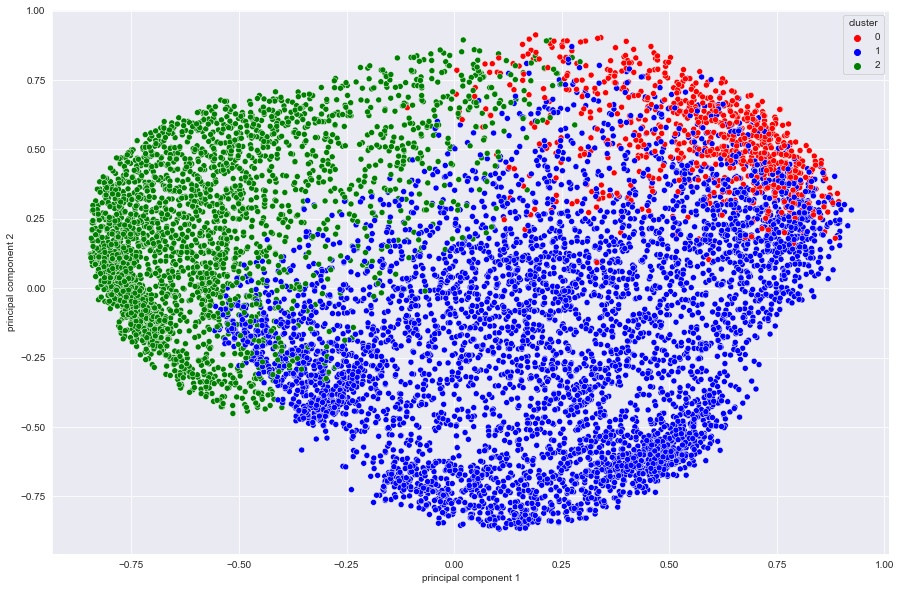

In [44]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x="principal component 1", y="principal component 2", hue="cluster", data=finalDf,palette=['red','blue','green'])
plt.show()